<a href="https://colab.research.google.com/github/AshwinAkash24/DL---RNN/blob/main/EX_05_Dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Ex. No .01
## DL- Developing a Recurrent Neural Network Model for Stock Prediction
## Reg.No: 212223230024
## Name: Ashwin Akash M

# Step:1 Import Iibraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

## Step 2: Load and Preprocess Data
# Load training and test datasets

In [4]:
df_train = pd.read_csv('trainset.csv')
df_test = pd.read_csv('testset.csv')

In [5]:
train_prices = df_train['Close'].values.reshape(-1, 1)
test_prices = df_test['Close'].values.reshape(-1, 1)

# Normalize the data based on training set only

In [6]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_prices)
scaled_test = scaler.transform(test_prices)

In [7]:
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

seq_length = 60
x_train, y_train = create_sequences(scaled_train, seq_length)
x_test, y_test = create_sequences(scaled_test, seq_length)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create dataset and dataloader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Step 3: Define RNN Model

In [8]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1,hidden_size=64,num_layers=2,output_size=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc  = nn.Linear(hidden_size,output_size)
    def forward(self, x):
        out,_=self.rnn(x)
        out=self.fc(out[:,-1,:])
        return out

model = RNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [9]:
!pip install torchinfo

In [10]:
from torchinfo import summary

# input_size = (batch_size, seq_len, input_size)
summary(model, input_size=(64, 60, 1))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## Step 4: Train the Model

In [11]:
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    train_losses = []
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch =x_batch.to(device),y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}")
# Plot training loss
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

Epoch [1/20], Loss: 0.0782
Epoch [2/20], Loss: 0.0166
Epoch [3/20], Loss: 0.0021
Epoch [4/20], Loss: 0.0008
Epoch [5/20], Loss: 0.0005
Epoch [6/20], Loss: 0.0004
Epoch [7/20], Loss: 0.0004
Epoch [8/20], Loss: 0.0004
Epoch [9/20], Loss: 0.0004
Epoch [10/20], Loss: 0.0004
Epoch [11/20], Loss: 0.0004
Epoch [12/20], Loss: 0.0004
Epoch [13/20], Loss: 0.0004
Epoch [14/20], Loss: 0.0003
Epoch [15/20], Loss: 0.0003
Epoch [16/20], Loss: 0.0003
Epoch [17/20], Loss: 0.0003
Epoch [18/20], Loss: 0.0003
Epoch [19/20], Loss: 0.0003
Epoch [20/20], Loss: 0.0003


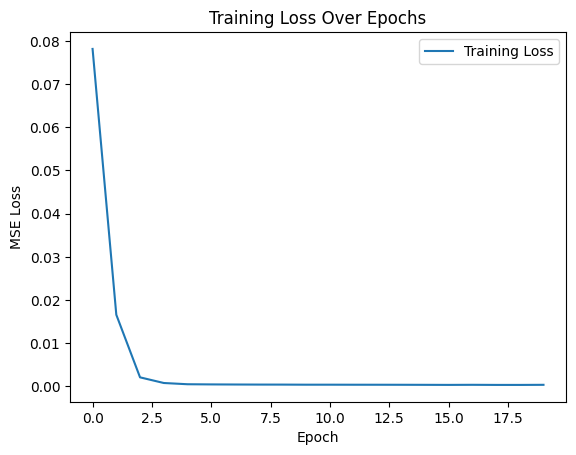

In [12]:
train_model(model,train_loader,criterion,optimizer)

## Step 5: Make Predictions on Test Set

In [13]:
model.eval()
with torch.no_grad():
    predicted = model(x_test_tensor.to(device)).cpu().numpy()
    actual = y_test_tensor.cpu().numpy()

# Inverse transform the predictions and actual values
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(actual)

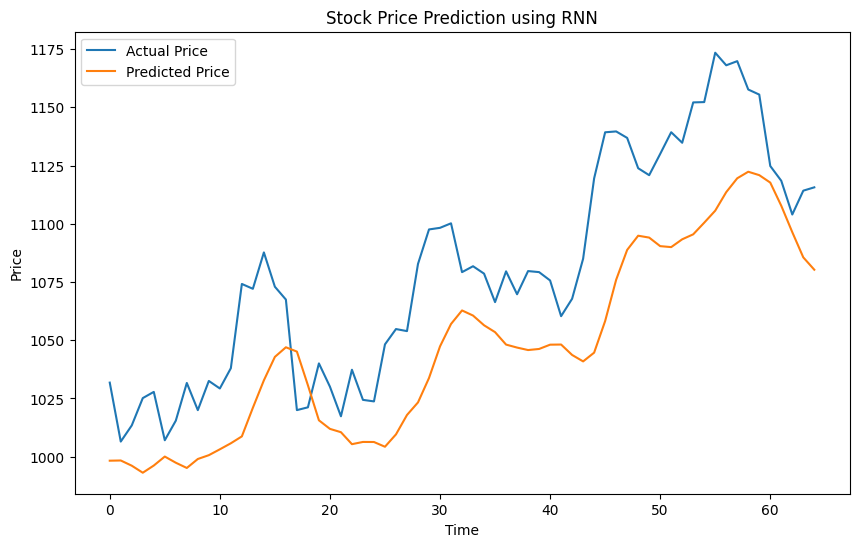

Predicted Price: [1080.2692]
Actual Price: [1115.65]


In [14]:
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Prediction using RNN')
plt.legend()
plt.show()
print(f'Predicted Price: {predicted_prices[-1]}')
print(f'Actual Price: {actual_prices[-1]}')